/tmp/ipykernel_33/3208714546.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Input dimension (input_dim): 18
Possible nhead values: [1, 2, 3, 6, 9, 18]
Chosen nhead: 18
Epoch 1/10, Train Loss: 0.0110, Val Loss: 0.0003, Test Loss: 0.0005, Time: 12.89s
Epoch 2/10, Train Loss: 0.0020, Val Loss: 0.0115, Test Loss: 0.0143, Time: 12.46s
Epoch 3/10, Train Loss: 0.0019, Val Loss: 0.0001, Test Loss: 0.0003, Time: 12.12s
Epoch 4/10, Train Loss: 0.0010, Val Loss: 0.0005, Test Loss: 0.0017, Time: 12.03s
Epoch 5/10, Train Loss: 0.0010, Val Loss: 0.0026, Test Loss: 0.0052, Time: 12.44s
Epoch 6/10, Train Loss: 0.0011, Val Loss: 0.0001, Test Loss: 0.0002, Time: 11.79s
Epoch 7/10, Train Loss: 0.0019, Val Loss: 0.0037, Test Loss: 0.0072, Time: 12.20s
Epoch 8/10, Train Loss: 0.0009, Val Loss: 0.0004, Test Loss: 0.0017, Time: 12.11s
Epoch 9/10, Train Loss: 0.0008, Val Loss: 0.0012, Test Loss: 0.0037, Time: 12.15s
Epoch 10/10, Train Loss: 0.0007, Val Loss: 0.0025, Test Loss: 0.0061, Time: 12.33s


/tmp/ipykernel_33/3208714546.py:161: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 2)


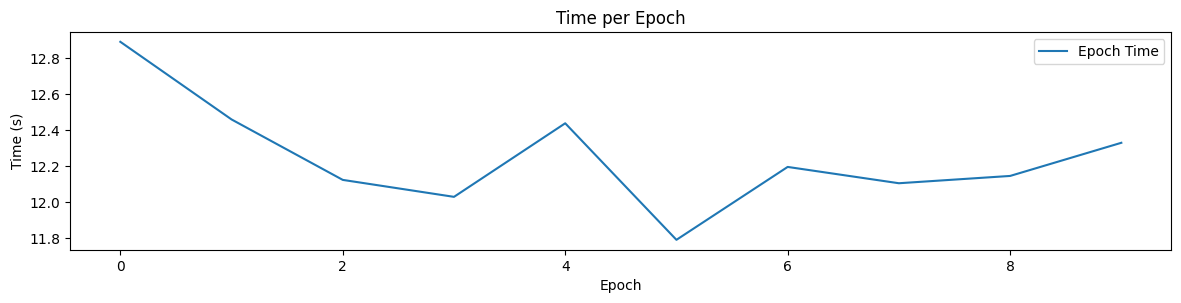

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

# Veri setini yükleyin
df = pd.read_csv('../input/timeseries/finalData.csv')

# Tarih sütununu datetime formatına çevirin
df['Date'] = pd.to_datetime(df['Date'])

# Tarih sütununu indeks olarak ayarlayın
df.set_index('Date', inplace=True)

# Eksik verileri kontrol edin ve doldurun (gerekirse)
df.fillna(method='ffill', inplace=True)

# Fiyat sütunlarını normalize edin
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Veriyi geri DataFrame formatına dönüştürün
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

# Eğitim, doğrulama ve test kümelerini oluşturun
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size
train, val, test = df_scaled[:train_size], df_scaled[train_size:train_size+val_size], df_scaled[train_size+val_size:]

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length][3]  # Kapanış fiyatını tahmin ettiğimizi varsayıyoruz
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 60  # 60 günlük sekanslar
X_train, y_train = create_sequences(train.values, seq_length)
X_val, y_val = create_sequences(val.values, seq_length)
X_test, y_test = create_sequences(test.values, seq_length)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, hidden_dim):
        super(TransformerModel, self).__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=hidden_dim),
            num_layers
        )
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, src):
        output = self.transformer_encoder(src)
        output = output.transpose(1, 2)  # (batch_size, seq_length, input_dim) -> (batch_size, input_dim, seq_length)
        output = self.global_avg_pool(output)  # (batch_size, input_dim, seq_length) -> (batch_size, input_dim, 1)
        output = output.squeeze(-1)  # (batch_size, input_dim, 1) -> (batch_size, input_dim)
        output = self.fc(output)
        output = self.output_layer(output)
        return output

# Ensure input_dim is divisible by nhead
input_dim = X_train.shape[2]
print(f"Input dimension (input_dim): {input_dim}")

# Find the largest `nhead` that is a divisor of `input_dim`
possible_nheads = [i for i in range(1, input_dim+1) if input_dim % i == 0]
print(f"Possible nhead values: {possible_nheads}")

# Choose a valid `nhead` from the possible values
nhead = possible_nheads[-1] if 8 not in possible_nheads else 8
print(f"Chosen nhead: {nhead}")

num_layers = 4
hidden_dim = 128

model = TransformerModel(input_dim, nhead, num_layers, hidden_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Tensor veri kümelerini oluşturma
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

# DataLoader'ları oluşturma
batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

# Modeli eğitme
def train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=10):
    train_losses = []
    val_losses = []
    test_losses = []
    epoch_times = []
    for epoch in range(epochs):
        start_time = time.time()
        
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item() * inputs.size(0)
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                test_loss += loss.item() * inputs.size(0)
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)

        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, Time: {epoch_time:.2f}s')

    return train_losses, val_losses, test_losses, epoch_times

# Modeli eğitme
train_losses, val_losses, test_losses, epoch_times = train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=10)

# Eğitim, doğrulama ve test kayıplarını görselleştirme
plt.figure(figsize=(12, 8))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(epoch_times, label='Epoch Time')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Time per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


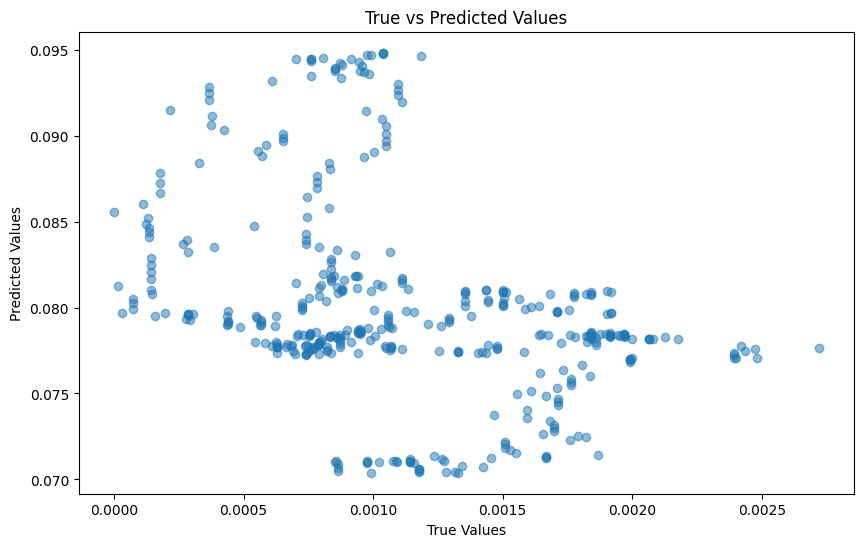

In [4]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values')
    plt.show()

# Test verileri üzerinde modelin tahminlerini yapma
model.eval()
with torch.no_grad():
    predictions = model(torch.from_numpy(X_test).float()).squeeze().numpy()

# Tahminleri ve gerçek hedef değerleri görselleştirme
plot_predictions(y_test, predictions)


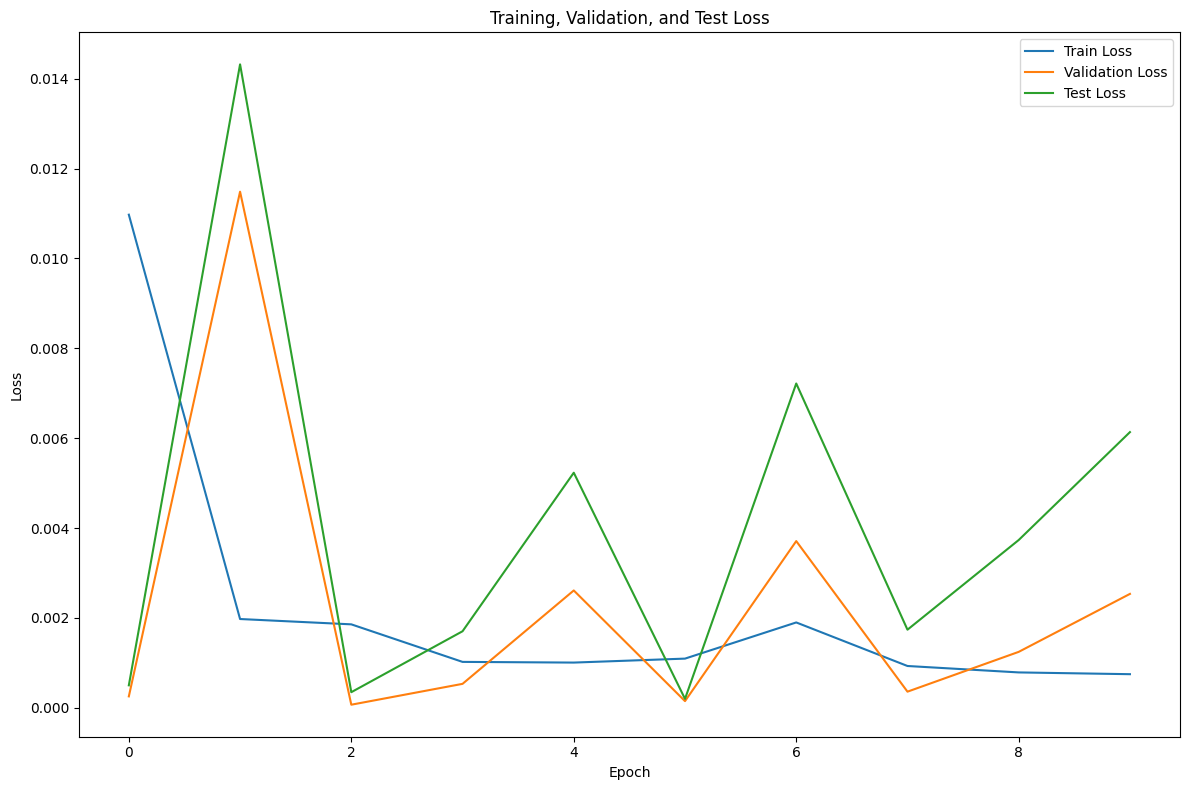

In [2]:
plt.figure(figsize=(12, 8))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()



plt.tight_layout()
plt.show()


IndexError: list index out of range

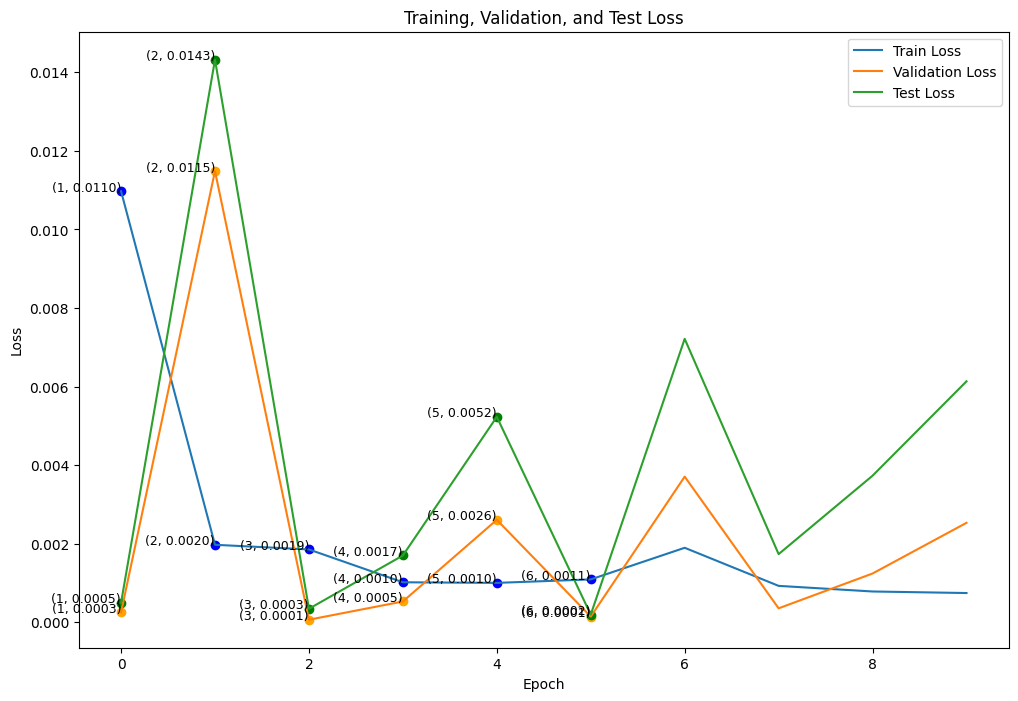

In [3]:
import matplotlib.pyplot as plt

def plot_losses_at_epochs(train_losses, val_losses, test_losses, epochs_to_plot):
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.legend()
    
    for epoch in epochs_to_plot:
        plt.scatter(epoch-1, train_losses[epoch-1], color='blue', marker='o', label='Train Loss' if epoch == epochs_to_plot[0] else "")
        plt.text(epoch-1, train_losses[epoch-1], f"({epoch}, {train_losses[epoch-1]:.4f})", fontsize=9, ha='right')
        
        plt.scatter(epoch-1, val_losses[epoch-1], color='orange', marker='o', label='Validation Loss' if epoch == epochs_to_plot[0] else "")
        plt.text(epoch-1, val_losses[epoch-1], f"({epoch}, {val_losses[epoch-1]:.4f})", fontsize=9, ha='right')
        
        plt.scatter(epoch-1, test_losses[epoch-1], color='green', marker='o', label='Test Loss' if epoch == epochs_to_plot[0] else "")
        plt.text(epoch-1, test_losses[epoch-1], f"({epoch}, {test_losses[epoch-1]:.4f})", fontsize=9, ha='right')

    plt.show()

# Örnek olarak 1., 3. ve son epoch'lardaki kayıpları ve grafiği gösterelim
epochs_to_plot = [1,2,3,4,5,6,48]
plot_losses_at_epochs(train_losses, val_losses, test_losses, epochs_to_plot)

